### Import libraries

In [ ]:
!cp -r ../input/earlystopping/early-stopping-pytorch-master/* ./
from pytorchtools import EarlyStopping

In [ ]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import seaborn as sns
import matplotlib.pyplot as plt
import cv2
import random
import matplotlib.image as img
# import warnings
import warnings
# filter warnings
warnings.filterwarnings('ignore')

import os

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from torch.utils.data import RandomSampler
from torch.utils.data import TensorDataset
from torchvision.utils import make_grid
import torchvision.models as models

### Loading training and validation data

In [ ]:
##### training data #####
train_csv = pd.read_csv("../input/mis583-2020-hw3/data/train.csv")
training_label = train_csv['label']
training_set = np.zeros((len(training_label), 3, 256, 256), dtype = "float64")
index = "../input/mis583-2020-hw3/"
i = 0
for path in train_csv['file_path']:
    image_path = index+path[2:]
    image = cv2.imread(image_path, cv2.IMREAD_COLOR)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB).astype(np.float32)
    image = cv2.resize(image, dsize=(256, 256), interpolation=cv2.INTER_CUBIC).transpose(2,0,1) /255.0
    training_set[i, :, :, :] = image
    i += 1

train_random_sampler = RandomSampler(training_set)
training_dataset = TensorDataset(torch.Tensor(training_set), torch.Tensor(training_label))
train_data_loader = DataLoader(
    dataset = training_dataset,
    batch_size = 16,
    sampler = train_random_sampler,
    num_workers = 4,
)

##### validation #####
val_csv = pd.read_csv("../input/mis583-2020-hw3/data/val.csv")
validation_label = val_csv['label']
validation_set = np.zeros((len(validation_label), 3, 256, 256), dtype = "float64")
i = 0
for path in val_csv['file_path']:
    image_path = index+path[2:]
    image = cv2.imread(image_path, cv2.IMREAD_COLOR)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB).astype(np.float32)
    image = cv2.resize(image, dsize=(256, 256), interpolation=cv2.INTER_CUBIC).transpose(2,0,1) /255.0
    validation_set[i, :, :, :] = image
    i += 1
 
val_random_sampler = RandomSampler(validation_set)
validation_dataset = TensorDataset(torch.Tensor(validation_set), torch.Tensor(validation_label))
val_data_loader = DataLoader(
    dataset = validation_dataset,
    batch_size = 16,
    sampler = val_random_sampler,
    num_workers = 4,
)


In [ ]:
del training_set,validation_set

### Preview of the dataframe 

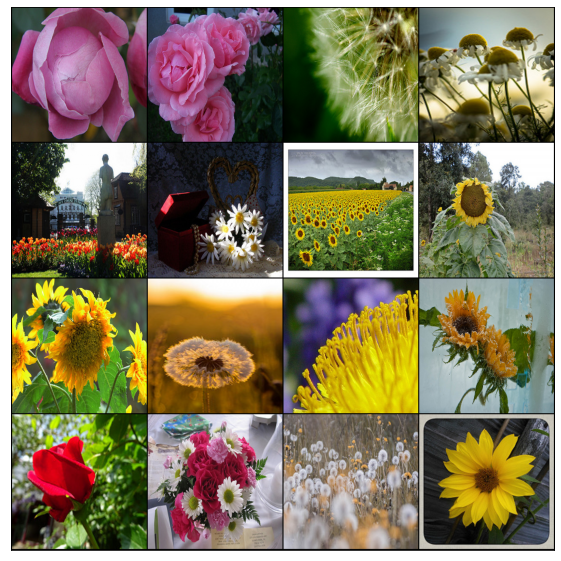

In [ ]:
for images, labels in train_data_loader:
    fig, ax = plt.subplots(figsize = (10, 10))
    ax.set_xticks([])
    ax.set_yticks([])
    ax.imshow(make_grid(images, 4).permute(1,2,0))
    break

### Defining nural network structure

In [ ]:
class Your_CNN_Model(nn.Module):
    def __init__(self):
        super().__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=11, stride=4, padding=2),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
			nn.MaxPool2d(kernel_size=3, stride=2),
			nn.Conv2d(64, 192, kernel_size=5, stride=1, padding=2),
            nn.BatchNorm2d(192),
			nn.ReLU(inplace=True),
			nn.MaxPool2d(kernel_size=3, stride=2),
			nn.Conv2d(192, 384, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(384),
            nn.ReLU(inplace=True),
            nn.Conv2d(384, 256, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(256),
			nn.ReLU(inplace=True),
			nn.Conv2d(256, 256, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(256),
			nn.ReLU(inplace=True),
			nn.MaxPool2d(kernel_size=3, stride=2),
            nn.AdaptiveAvgPool2d((6, 6))

		)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        x = self.features(x)
        x = x.view(x.size(0), -1)
        x = self.classifier(x)
        return x

In [ ]:
model = models.alexnet()
model.classifier = nn.Sequential(
    nn.Linear(9216, 4096, bias = True),
    nn.ReLU(inplace = True),
    nn.Dropout(0.4),
    nn.Linear(4096, 2048, bias = True),
    nn.ReLU(inplace = True),
    nn.Dropout(0.4),
    nn.Linear(2048, 5)
)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
torch.cuda.empty_cache()

model.to(device)

optimizer = torch.optim.Adam(model.parameters(), lr = 0.0001)
lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size = 5, gamma = 0.75)
criterion = nn.CrossEntropyLoss()

train_loss = []
train_accuracy = []

val_loss = []
val_accuracy = []

### Defining a function to calculate accuracy

In [ ]:
def calc_accuracy(true,pred):
    pred = F.softmax(pred, dim = 1)
    true = torch.tensor(true, dtype = torch.int64)
    true = torch.zeros(pred.shape[0], pred.shape[1]).scatter_(1, true.unsqueeze(1), 1.)
    acc = (true.argmax(-1) == pred.argmax(-1)).float().detach().numpy()
    acc = float((100 * acc.sum()) / len(acc))
    return round(acc, 4)

### Starting training

In [ ]:
import time
epochs = 500
patience = 30
early_stopping = EarlyStopping(patience=patience, verbose=True)
for epoch in range(epochs):
    
    start = time.time()
    #Epoch Loss & Accuracy
    train_epoch_loss = []
    train_epoch_accuracy = []
    _iter = 1
    
    #Val Loss & Accuracy
    val_epoch_loss = []
    val_epoch_accuracy = []
    
    for image, label in train_data_loader:
        
        image = image.to(device).float()
        label = label.to(device).long()
        
        optimizer.zero_grad()
        pred = model(image)
        
        acc = calc_accuracy(label.cpu(), pred.cpu())
        
        loss = criterion(pred, label)
        loss.backward()
        optimizer.step()
        
        loss_value = loss.item()
        train_epoch_loss.append(loss_value)
        train_epoch_accuracy.append(acc)
        
        if _iter % 500 == 0:
            print("> Iteration {} < ".format(_iter))
            print("Iter Loss = {}".format(round(loss_value, 4)))
            print("Iter Accuracy = {} % \n".format(acc))
        
        _iter += 1
        
    #Validation
    for image, label in val_data_loader:
        
        image = image.to(device).float()
        label = label.to(device).long()
        
        #Forward ->
        pred = model(image)
        
        #Calculate Accuracy
        acc = calc_accuracy(label.cpu(), pred.cpu())
        
        #Calculate Loss
        loss = criterion(pred, label)
        
        #Append loss & acc
        loss_value = loss.item()
        val_epoch_loss.append(loss_value)
        val_epoch_accuracy.append(acc)
    
    
    train_epoch_loss = np.mean(train_epoch_loss)
    train_epoch_accuracy = np.mean(train_epoch_accuracy)
    
    val_epoch_loss = np.mean(val_epoch_loss)
    val_epoch_accuracy = np.mean(val_epoch_accuracy)
    
    end = time.time()
    
    early_stopping(val_epoch_loss, model)
    if early_stopping.early_stop:
        print("Early stopping")
        break
    
    train_loss.append(train_epoch_loss)
    train_accuracy.append(train_epoch_accuracy)
    
    val_loss.append(val_epoch_loss)
    val_accuracy.append(val_epoch_accuracy)
    
    #Print Epoch Statistics
    print("** Epoch {} ** - Epoch Time {}".format(epoch, int(end-start)))
    print("Train Loss = {}".format(round(train_epoch_loss, 4)))
    print("Train Accuracy = {} % \n".format(train_epoch_accuracy))
    print("Val Loss = {}".format(round(val_epoch_loss, 4)))
    print("Val Accuracy = {} % \n".format(val_epoch_accuracy))
    
model.load_state_dict(torch.load('checkpoint.pt'))   

Validation loss decreased (inf --> 1.294768).  Saving model ...
** Epoch 0 ** - Epoch Time 8
Train Loss = 1.4544
Train Accuracy = 33.26923076923077 % 

Val Loss = 1.2948
Val Accuracy = 39.94897959183673 % 

Validation loss decreased (1.294768 --> 1.151346).  Saving model ...
** Epoch 1 ** - Epoch Time 7
Train Loss = 1.2416
Train Accuracy = 45.06410256410256 % 

Val Loss = 1.1513
Val Accuracy = 50.86734693877551 % 

Validation loss decreased (1.151346 --> 1.143125).  Saving model ...
** Epoch 2 ** - Epoch Time 8
Train Loss = 1.142
Train Accuracy = 50.06410256410256 % 

Val Loss = 1.1431
Val Accuracy = 52.704081632653065 % 

Validation loss decreased (1.143125 --> 1.077563).  Saving model ...
** Epoch 3 ** - Epoch Time 7
Train Loss = 1.045
Train Accuracy = 56.31410256410256 % 

Val Loss = 1.0776
Val Accuracy = 54.15816326530612 % 

Validation loss decreased (1.077563 --> 1.000446).  Saving model ...
** Epoch 4 ** - Epoch Time 7
Train Loss = 0.9306
Train Accuracy = 63.75 % 

Val Loss = 1.

<All keys matched successfully>

## Prediction

### Loading testing data

In [ ]:
test_csv = pd.read_csv("../input/mis583-2020-hw3/data/test.csv")
testing_set = np.zeros((len(test_csv), 3, 256, 256), dtype = "float64")
i = 0
for path in test_csv['file_path']:
    image_path = index+path[2:]
    image = cv2.imread(image_path, cv2.IMREAD_COLOR)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB).astype(np.float32)
    image = cv2.resize(image, dsize=(256, 256), interpolation=cv2.INTER_CUBIC).transpose(2,0,1) /255.0
    testing_set[i, :, :, :] = image
    i += 1


### Predicting

In [ ]:
testing_dataset = torch.Tensor(testing_set).to(device).float()
prediction = model(testing_dataset)
prediction = F.softmax(prediction, dim = 1)
prediction = prediction.argmax(-1).cpu().numpy()

### Writing in the file

In [ ]:
import csv

path = 'submission.csv'
with open(path, 'w', newline='') as csvfile:
    writer = csv.writer(csvfile)
    writer.writerow(['id','Category'])
    for i in range(len(test_csv)):
        writer.writerow([i+1,prediction[i]])